In [114]:
#import all necessary packages
import gurobipy as gp
from gurobipy import GRB
from gerrychain import Graph
import networkx as nx
import geopandas as gpd
import math

In [115]:
#Set filepath and filename equal to the path/name of the data used respectively
filepath = 'C:/Users/Logan/Desktop\College/IEM4013Project/'
filename= 'AR_county.json'
#Create a new Graph object G from the file
G = Graph.from_json(filepath + filename)

In [116]:
#Set each node in G to be equal to the population of their respective county
for node in G.nodes:
    G.nodes[node]['TOTPOP'] = G.nodes[node]['P0010001']

In [117]:
#Print each node, the county it represents, and their 2020 population
for node in G.nodes:
    name = G.nodes[node]['NAME20']
    population = G.nodes[node]['TOTPOP']
    print("Node",node,"represents",name,"County with 2020 population of",population)

Node 0 represents Franklin County with 2020 population of 17097
Node 1 represents Crawford County with 2020 population of 60133
Node 2 represents Jackson County with 2020 population of 16755
Node 3 represents Clay County with 2020 population of 14552
Node 4 represents Faulkner County with 2020 population of 123498
Node 5 represents Baxter County with 2020 population of 41627
Node 6 represents Little River County with 2020 population of 12026
Node 7 represents Boone County with 2020 population of 37373
Node 8 represents Ashley County with 2020 population of 19062
Node 9 represents Desha County with 2020 population of 11395
Node 10 represents St. Francis County with 2020 population of 23090
Node 11 represents Montgomery County with 2020 population of 8484
Node 12 represents Sharp County with 2020 population of 17271
Node 13 represents Greene County with 2020 population of 45736
Node 14 represents Woodruff County with 2020 population of 6269
Node 15 represents White County with 2020 popul

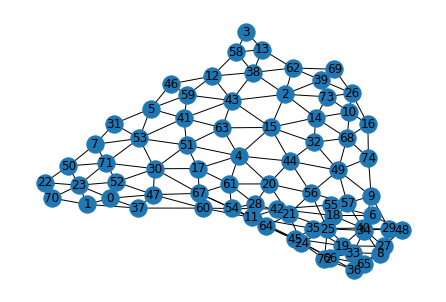

In [118]:
#draw the graph of nodes
nx.draw(G, with_labels=True)

In [119]:
#set the ceiling and floor of the model equal to the maximum deviation/2 * the average population
dev = 0.01

k = 4
tot_pop = sum(G.nodes[node]['TOTPOP'] for node in G.nodes)

L = math.ceil((1-dev/2)*tot_pop/k)
U = math.floor((1+dev/2)*tot_pop/k)
print("Using L =",L,"and U =",U,"and k =",k)

Using L = 749117 and U = 756645 and k = 4


In [120]:
#create a new model object and create variables
m = gp.Model()

x = m.addVars(G.nodes, k, vtype=GRB.BINARY)
y = m.addVars(G.edges, vtype=GRB.BINARY)

In [121]:
#set objective to minimize cut edges
m.setObjective( gp.quicksum( y[u,v] for u,v in G.edges ), GRB.MINIMIZE )

In [122]:
# each county i is assigned to a district j
m.addConstrs(gp.quicksum(x[i,j] for j in range(k)) == 1 for i in G.nodes)
# each district j has a population at least L and at most U
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) >= L for j in range(k))
m.addConstrs( gp.quicksum( G.nodes[i]['TOTPOP'] * x[i,j] for i in G.nodes) <= U for j in range(k))
# an edge is cut if u is assigned to district j but v is not.
m.addConstrs( x[u,j] - x[v,j] <= y[u,v] for u,v in G.edges for j in range(k))
m.update()

In [123]:
# add root variables: r[i,j] equals 1 if node i is the root of district j
r = m.addVars( G.nodes, k, vtype=GRB.BINARY)

import networkx as nx 

DG = nx.DiGraph(G)

f = m.addVars(DG.edges)

In [124]:
# The big-M proposed by Hojny et al.
M = G.number_of_nodes() - k + 1
# each district should have one root
m.addConstrs( gp.quicksum( r[i,j] for i in G.nodes ) == 1 for j in range(k) )
# If node i isn't assigned to district j, then it cannot be its root
m.addConstrs( r[i,j] <= x[i,j] for i in G.nodes for j in range(k) )
# If not a root, consume some flow
# If a root, only send out (so much) flow
m.addConstrs( gp.quicksum( f[j,i] - f[i,j] for j in G.neighbors(i) ) 
             >= 1 - M * gp.quicksum( r[i,j] for j in range(k) ) for i in G.nodes )
# Do not send flow across cut edges
m.addConstrs( f[i,j] + f[j,i] <= M * (1-y[i,j] )for i,j in G.edges)

m.update()

In [109]:
# sole IP model
m.optimize()

Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (win64)
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads
Optimize a model with 1422 rows, 1176 columns and 5748 nonzeros
Model fingerprint: 0xde32f915
Variable types: 384 continuous, 792 integer (792 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+05]
  Objective range  [2e-03, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 8e+05]
Presolve time: 0.01s
Presolved: 1422 rows, 1176 columns, 5748 nonzeros
Variable types: 384 continuous, 792 integer (792 binary)

Root relaxation: objective 0.000000e+00, 608 iterations, 0.01 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0  316          -    0.00000      -     -    0s
     0     0    0.05446    0  331          -    0.05446      -     -    0s
     0     0    1.67416    0  321    

In [110]:
print("The number of cut edges is",m.objval)

# retrieve the districts and their population
districts = [[i for i in G.nodes if x[i,j].x > 0.5] for j in range(k)]
district_counties = [[G.nodes[i]["NAME20"] for i in districts[j] ] for j in range(k)]
district_populations = [sum(G.nodes[i]["TOTPOP"] for i in districts[j]) for j in range(k)]
# print it
for j in range(k):
    print("District",j,"has population",district_populations[j],"and contains counties",district_counties[j])
    print("")

The number of cut edges is 12.00964554654077
District 0 has population 751754 and contains counties ['Franklin', 'Crawford', 'Benton', 'Madison', 'Sebastian', 'Washington']

District 1 has population 754435 and contains counties ['Jackson', 'Clay', 'Baxter', 'Boone', 'St. Francis', 'Sharp', 'Greene', 'Woodruff', 'White', 'Lee', 'Crittenden', 'Marion', 'Prairie', 'Lawrence', 'Poinsett', 'Stone', 'Independence', 'Fulton', 'Carroll', 'Van Buren', 'Searcy', 'Randolph', 'Izard', 'Craighead', 'Cleburne', 'Monroe', 'Mississippi', 'Newton', 'Cross']

District 2 has population 750788 and contains counties ['Faulkner', 'Conway', 'Pulaski', 'Saline', 'Lonoke', 'Perry']

District 3 has population 754547 and contains counties ['Little River', 'Ashley', 'Desha', 'Montgomery', 'Howard', 'Nevada', 'Grant', 'Dallas', 'Cleveland', 'Lafayette', 'Chicot', 'Pope', 'Bradley', 'Drew', 'Pike', 'Union', 'Hempstead', 'Polk', 'Clark', 'Logan', 'Miller', 'Arkansas', 'Johnson', 'Garland', 'Sevier', 'Jefferson', 'L

In [113]:
# Read Oklahoma county shapefile from "OK_county.shp"
filepath = 'C:/Users/Logan/Desktop\College/IEM4013Project/'
filename = 'AR_county.shp'
# Read geopandas dataframe from file
df = gpd.read_file( filepath + filename)

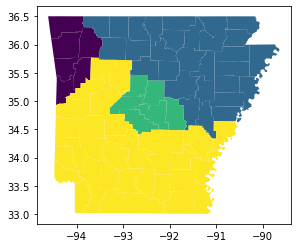

In [112]:
# Which district is each county assigned to?
assignment = [ -1 for i in G.nodes ]

labeling = { i : j for i in G.nodes for j in range(k) if x[i,j].x > 0.5 }
# add assignments to a column of the dataframe and map it
node_with_this_geoid = { G.nodes[i]['GEOID20'] : i for i in G.nodes }
# pick a position u in the data frame
for u in range(G.number_of_nodes()):
    
    geoid = df['GEOID20'][u]
    i = node_with_this_geoid[geoid]
    assignment[u] = labeling[i]
#print the map    
df['assignment'] = assignment
my_fig = df.plot(column='assignment').get_figure()